In [1]:
import numpy as np
from bisect import bisect_left
from functions import base_function

Для начала приведу код, при помощи которого решаются линейные системы уравнения вида $$ A * x = b $$
Матрица $A$ раскладывалась при помощи $LUP$ разложения, которое заключается в поиске матриц $L$, $U$, $P$, где $L$ -- нижнетреугольная с единичной главной диагональю, $U$ -- верхнетреугольная, а $P$ получается перестановкой строк в единичной матрице, удовлетворяющих следующему равенству:
$$ P * A = L * U $$
.
В отличие от $LU$ разложения, $LUP$ разложение применимо к любой обратимой матрице. Это достигается за счёт того, что на каждой итерации мы меняем строчки наших матриц так, чтобы на очередной диагонали стоял максимальный по модулю элемент среди строчек ниже. То есть на $i$ итерации мы меняем строку $i$ со строкой $j > i$, где
$$ j: max(|U[j][i]|), j >= i $$


Это изменение мы отмечаем, поменяв соответствующие строчки в матрице $P$.

In [2]:
def make_lup_decomposition(A):
    C = np.copy(A)
    P = np.zeros(A.shape)
    for i in range(0, A.shape[0]):
        P[i][i] = 1.0
    for i in range(0, A.shape[1]):
        max_row = -1
        max_row_val = 0.0
        for row in range(i, A.shape[0]):
            if np.abs(C[row][i]) > max_row_val:
                max_row = row
                max_row_val = C[row][i]
        
        if max_row_val == 0:
            return None

        temp_row = np.copy(C[i, :])
        C[i, :] = np.copy(C[max_row, :])
        C[max_row, :] = temp_row
        temp_row = np.copy(P[i, :])
        P[i, :] = np.copy(P[max_row, :])
        P[max_row, :] = temp_row
        
        for j in range(i + 1, A.shape[0]):
            C[j][i] /= C[i][i]
            for k in range(i + 1, A.shape[1]):
                C[ j ][ k ] -= C[ j ][ i ] * C[ i ][ k ]
    
    L = np.zeros(A.shape)
    U = np.zeros(A.shape)
    for row in range(A.shape[0]):
        for col in range(A.shape[1]):
            if col >= row:
                U[row][col] = C[row][col]
            if row == col:
                L[row][col] = 1
            if col < row:
                L[row][col] = C[row][col]
    
    return (L, U, P)

Когда мы написали lup-разложение, решение системы линейных уравнений разбивается на решение двух систем. Пусть
$$ Ax = b$$
Тогда можно домножить на матрицу P
$$PAx = Pb$$
Распишем $PA$
$$LUx = Pb$$
Получаем 2 системы линейных уравнений
$$Ly = Pb$$
$$Ux = y$$
Так как $L$ -- нижнетреугольная, а $U$ верхнетреугольная, то соответствующие системы уравнений решаются обычной прогонкой

In [3]:
def solve_linear_system(A, b):
    # Ax = b
    # PAx = Pb
    # LUx = Pb
    # Ly = Pb
    # Ux = y
    L, U, P = make_lup_decomposition(A)
    
    x = np.zeros(A.shape[1])
    y = np.zeros(A.shape[1])
    b = np.dot(P, b)
    
    # Ly = Pb
    for i in range(A.shape[0]):
        if i == 0:
            y[i] = b[i]
            continue
        temp_sum = sum(L[i][j] * y[j] for j in range(0, i))
        y[i] = b[i] - temp_sum
    
    for i in range(A.shape[0] - 1, -1, -1):
        if i == A.shape[0] - 1:
            x[i] = y[i] / U[i][i]
            continue
        temp_sum = sum(U[i][j] * x[j] for j in range(A.shape[0] - 1, i, -1))
        x[i] = (y[i] - temp_sum) / U[i][i]
    return x

Решим системы уравнений, задающиеся матрицами $A$, $B$, $C$

In [4]:
b = np.array([1, 1, 1], dtype=np.float)
A = np.array([[1, 2, 3], [2.0001, 3.999, 6], [15, 3, 6]], dtype=np.float)
B = np.array([[1, 1/2, 1/3], [1/2, 1/3, 1/4], [1/3, 1/4, 1/5]], dtype=np.float)
C = np.array([[10 ** 6, 2], [10 ** 13, 2]], dtype=np.float)
A_ans = solve_linear_system(A, b)
B_ans = solve_linear_system(B, b)
C_ans = solve_linear_system(C, np.array([1, 1]))

In [5]:
print("A error:", np.abs(b - np.dot(A, A_ans)))
print("A error:", np.abs(b - np.dot(B, B_ans)))
print("A error:", np.abs(np.array([1, 1]) - np.dot(C, C_ans)))

A error: [ 0.  0.  0.]
A error: [ 0.  0.  0.]
A error: [ 0.  0.]


Теперь интерполяция: класс скопирован из файла "functions/interpolated_function"

In [6]:
class InterpolatedFunction(base_function.BaseFunction):

    def __init__(self, tabulated_func_filename, points=None):
        params = self.calculate_interpolation_coeffs(tabulated_func_filename, points)
        super().__init__(params)

    def calculate_interpolation_coeffs(self, tabulated_func_filename, points=None):
        x = []
        f = []
        if points is not None:
            x = [point for point in points[0]]
            f = [point for point in points[1]]
        else:
            with open("tabulated_functions/" + tabulated_func_filename, 'r') as file:
                for line in file:
                    point = line.strip().split(' ')
                    x.append(float(point[0]))
                    f.append(float(point[1]))

        n = len(x) - 1
        A = np.zeros([n - 1, n - 1], dtype=type(1.0))
        h = [float(x[i] - x[i - 1]) for i in range(1, n + 1)]
        for i in range(0, n - 1):
            A[i][i] = 2 * (h[i] + h[i + 1])
        for i in range(1, n - 1):
            A[i][i - 1] = h[i]
            A[i - 1][i] = h[i]

        F = [6 * (((f[i + 1] - f[i]) / h[i]) - ((f[i] - f[i - 1]) / h[i - 1])) for i in range(1, n)]
        F = np.array(F, dtype=type(1.0))

        system_solution = self.solve_linear_system(A, F)
        self.a = f
        self.b = [0] * (n + 1)
        self.c = [0]
        self.d = [0] * (n + 1)
        for c_i in system_solution:
            self.c.append(c_i)
        self.c.append(0)

        for i in range(1, len(x)):
            self.d[i] = (self.c[i] - self.c[i - 1]) / h[i - 1]
            self.b[i] = h[i - 1] * (2.0 * self.c[i] + self.c[i - 1]) / 6.0 + (f[i] - f[i - 1]) / h[i - 1]
        self.x = x
        self.f = f
        return None

    def make_lup_decomposition(self, A):
        C = np.copy(A)
        P = np.zeros(A.shape)
        for i in range(0, A.shape[0]):
            P[i][i] = 1.0
        for i in range(0, A.shape[1]):
            max_row = -1
            max_row_val = 0.0
            for row in range(i, A.shape[0]):
                if np.abs(C[row][i]) > max_row_val:
                    max_row = row
                    max_row_val = C[row][i]
            
            if max_row_val == 0:
                return None
    
            temp_row = np.copy(C[i, :])
            C[i, :] = np.copy(C[max_row, :])
            C[max_row, :] = temp_row
            temp_row = np.copy(P[i, :])
            P[i, :] = np.copy(P[max_row, :])
            P[max_row, :] = temp_row
            
            for j in range(i + 1, A.shape[0]):
                C[j][i] /= C[i][i]
                for k in range(i + 1, A.shape[1]):
                    C[ j ][ k ] -= C[ j ][ i ] * C[ i ][ k ]
        
        L = np.zeros(A.shape)
        U = np.zeros(A.shape)
        for row in range(A.shape[0]):
            for col in range(A.shape[1]):
                if col >= row:
                    U[row][col] = C[row][col]
                if row == col:
                    L[row][col] = 1
                if col < row:
                    L[row][col] = C[row][col]
        
        return (L, U, P)

    def solve_linear_system(self, A, b):
        # Ax = b
        # PAx = Pb
        # LUx = Pb
        # Ly = Pb
        # Ux = y
        L, U, P = self.make_lup_decomposition(A)
        
        x = np.zeros(A.shape[1])
        y = np.zeros(A.shape[1])
        b = np.dot(P, b)
        
        # Ly = Pb
        for i in range(A.shape[0]):
            if i == 0:
                y[i] = b[i]
                continue
            temp_sum = sum(L[i][j] * y[j] for j in range(0, i))
            y[i] = b[i] - temp_sum
        
        for i in range(A.shape[0] - 1, -1, -1):
            if i == A.shape[0] - 1:
                x[i] = y[i] / U[i][i]
                continue
            temp_sum = sum(U[i][j] * x[j] for j in range(A.shape[0] - 1, i, -1))
            x[i] = (y[i] - temp_sum) / U[i][i]
        return x

    def calculate(self, x):
        distribution = self.x
        i = bisect_left(distribution, x)
        if i == len(distribution):
            return 0
        dx = x - self.x[i]
        return self.a[i] + self.b[i] * dx + self.c[i] * dx**2 / 2. + self.d[i] * dx**3 / 6.


Тесты

In [7]:
class ContinuousFunc(base_function.BaseFunction):

    def __init__(self, params=None):
        pass

    def calculate(self, y):
        return np.sin(y)

In [8]:
class NonContinuousFunc(base_function.BaseFunction):
    
    def __init__(self, params=None):
        pass

    def calculate(self, y):
        return y * y if y < 1 else -y

In [9]:
class OscillatingFunction(base_function.BaseFunction):
    
    def __init__(self, params=None):
        pass

    def calculate(self, y):
        return np.cos(1000 * y)

In [10]:
cont_func = ContinuousFunc()
non_cont_func = NonContinuousFunc()
osc_func = OscillatingFunction()

In [11]:
points = np.linspace(0, 10, 100)
values = [cont_func.calculate(x) for x in points]
interp_func = InterpolatedFunction("random_name", points=[points, values])

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

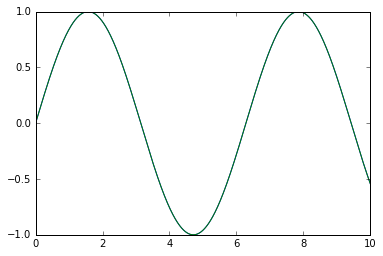

In [13]:
x = []
real_ans = []
interp_ans = []
for i in np.linspace(0, 10, 10000):
    x.append(i)
    real_ans.append(cont_func.calculate(i))
    interp_ans.append(interp_func.calculate(i))
plt.plot(x, real_ans, x, interp_ans)
plt.show()

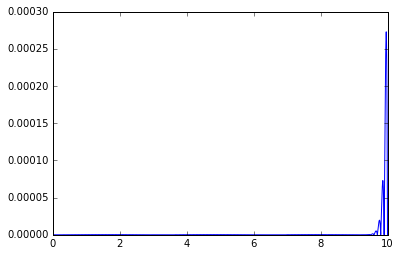

In [14]:
x = []
y = []
for i in np.linspace(0, 10, 10000):
    x.append(i)
    y.append(np.abs(cont_func.calculate(i) - interp_func.calculate(i)))
plt.plot(x, y)
plt.show()

Как мы видим, неприрывные функции кубический сплайн довольно неплохо приближает при большом разбиении

In [15]:
points = np.linspace(0, 10, 100)
values = [non_cont_func.calculate(x) for x in points]
interp_func = InterpolatedFunction("random_name", points=[points, values])

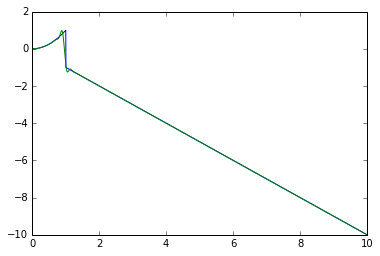

In [16]:
x = []
real_ans = []
interp_ans = []
for i in np.linspace(0, 10, 10000):
    x.append(i)
    real_ans.append(non_cont_func.calculate(i))
    interp_ans.append(interp_func.calculate(i))
plt.plot(x, real_ans, x, interp_ans)
plt.show()

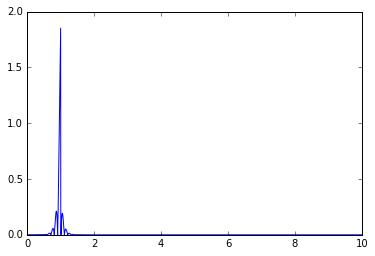

In [17]:
x = []
y = []
for i in np.linspace(0, 10, 10000):
    x.append(i)
    y.append(np.abs(non_cont_func.calculate(i) - interp_func.calculate(i)))
plt.plot(x, y)
plt.show()

В случае разрывных функций мы должны выбрать достаточно частое разбиение чтобы место разрыва как можно точнее приблизить. Ошибок, конечно, не избежать, но всё-таки

In [18]:
points = np.linspace(0, 5, 100)
values = [osc_func.calculate(x) for x in points]
interp_func = InterpolatedFunction("random_name", points=[points, values])

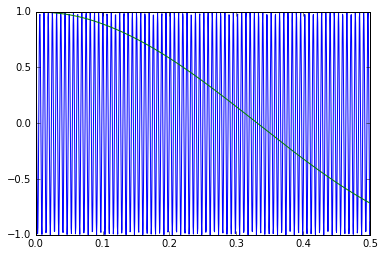

In [19]:
x = []
real_ans = []
interp_ans = []
for i in np.linspace(0, 0.5, 1000):
    x.append(i)
    real_ans.append(osc_func.calculate(i))
    interp_ans.append(interp_func.calculate(i))
plt.plot(x, real_ans, x, interp_ans)
plt.show()

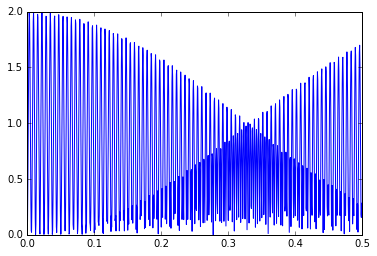

In [20]:
x = []
y = []
for i in np.linspace(0, 0.5, 1000):
    x.append(i)
    y.append(np.abs(osc_func.calculate(i) - interp_func.calculate(i)))
plt.plot(x, y)
plt.show()

А вот с осцилирующими функциями всё довольно плохо. Мы не можем взять достаточно частое разбиение (т.к на очень малых отрезках очень много $0$) и поэтому такие функции очень плохо приближаются.